<a href="https://colab.research.google.com/github/serjisa/transcriptomics.msu/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%D1%8B/05_%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 5. Функциональный анализ RNA-Seq

На прошлом занятии мы разобрались, как выполнять анализ дифференциальной экспрессии в bulk RNA-Seq, а сейчас мы займёмся следующей ступенью: осмыслению результатов.

In [ ]:
!pip3 install gseapy==0.10.8
!gdown 1saZcoMgLnhM-U9qZTKVVh5_y8nKdufH5
!wget https://raw.githubusercontent.com/BostonGene/MFP/master/signatures/gene_signatures.gmt

## ssGSEA

Мы начнём с того, что оценим выраженность различных сигнатур на выборке из 40 пациентов из TCGA с мелкоклеточным раком лёгкого (аденокарциномой). Сначала прочитаем сами экспрессии (TPM'ы) и сигнатуры.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("LUAD_tpms.tsv", sep="\t", index_col=0)
# check if its really tpms!!!

In [ ]:
signatures = {}

with open("gene_signatures.gmt") as f:
  for line in f.readlines():
    signatures[line.split("\t")[0]] = line.strip().split("\t")[2:]

А теперь запустим GSEApy и оценим выраженность сигнатур в этих образцах. Для примера мы взяли сигнатуры из <a href="https://www.cell.com/cancer-cell/fulltext/S1535-6108(21)00222-1">статьи</a>, в которой охарактеризовывают опухоли по выраженности экспрессионных иммуного микроокружения сигнатур в них.

In [ ]:
import gseapy as gp

ss = gp.ssgsea(
    data=df,
    gene_sets=signatures.copy(),
    outdir=None,
    min_size=3,
    sample_norm_method="rank",
    no_plot=True
)
ssGSEA = ss.res2d

Creating directory /root/.config/bioservices 


2022-10-07 14:29:41,200 Warning: dropping duplicated gene names, only keep the first values


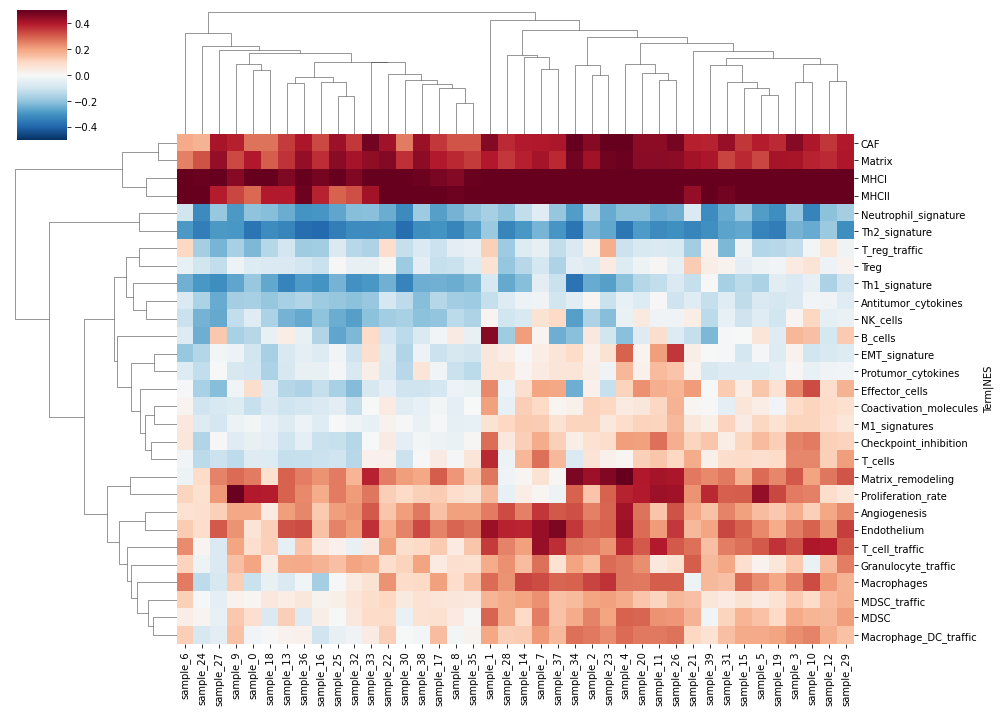

In [ ]:
sns.clustermap(ssGSEA, cmap="RdBu_r", vmin=-0.5, vmax=0.5, figsize=(14, 10), method="average")

Теперь мы можем увидеть, что образцы, которые мы анализируем, делятся на две группы в зависимости от выраженности экспрессионных сигнатур, и мы можем объяснить, почему они делятся именно на эти две группы.

## GSEA

Теперь давайте выполним стандартный GSEA с теми же генными наборами, что мы использовали в прошлый раз, и с кластерами, которые мы получили из ssGSEA. Сначала возьмём кластера, которые у нас получились на прошлом шаге.

In [ ]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

labels = ["low_immune" if i == 1 else "immune" for i in hierarchy.fcluster(
  hierarchy.linkage(distance.pdist(ssGSEA.T), method="average"),
  t=2,
  criterion="maxclust"
)]

Теперь запустим GSEA на этих кластерах.

In [ ]:
gs_res = gp.gsea(
    data=df,
    gene_sets=signatures.copy(),
    cls=labels,
    min_size=3,
    permutation_type="phenotype",
    permutation_num=1000,
    outdir=None,
    method="signal_to_noise"
)

2022-10-07 14:36:37,588 Warning: dropping duplicated gene names, only keep the first values


Посмотрим, какие сигнатуры наиболее значимо различают наши группы, и отрисуем GSEA plot для одного значимого и одного не значимого случая.

In [ ]:
gs_res.res2d

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Coactivation_molecules,-0.844764,-2.024157,0.000000,0.000000,14,14,ICOSLG;TNFSF9;TNFRSF4;CD70;TNFRSF9;CD27;TNFSF4...,TNFRSF9;CD27;TNFSF4;CD40LG;CD83;CD28;ICOS;CD80...
Checkpoint_inhibition,-0.918716,-1.927171,0.000000,0.003035,9,9,LAG3;BTLA;CD274;CTLA4;VSIR;TIGIT;PDCD1;HAVCR2;...,BTLA;CD274;CTLA4;VSIR;TIGIT;PDCD1;HAVCR2;PDCD1LG2
Macrophage_DC_traffic,-0.890048,-1.896273,0.000000,0.008093,8,8,XCL1;CCL8;CCL7;XCR1;CSF1;CCL2;CSF1R;CCR2,CCL8;CCL7;XCR1;CSF1;CCL2;CSF1R;CCR2
T_cell_traffic,-0.858272,-1.821108,0.006122,0.017805,9,9,CX3CL1;CXCL11;CX3CR1;CXCR3;CXCL10;CCL3;CXCL9;C...,CXCL11;CX3CR1;CXCR3;CXCL10;CCL3;CXCL9;CCL5;CCL4
Macrophages,-0.922321,-1.832630,0.001942,0.020233,8,8,MRC1;CD68;SIGLEC1;MSR1;IL10;CSF1R;CD163;IL4I1,MRC1;CD68;SIGLEC1;MSR1;IL10;CSF1R;CD163;IL4I1
M1_signatures,-0.756424,-1.740339,0.008368,0.026753,9,9,IL12B;SOCS3;IL23A;IL12A;NOS2;IRF5;TNF;CMKLR1;IL1B,SOCS3;IL23A;IL12A;NOS2;IRF5;TNF;CMKLR1;IL1B
Antitumor_cytokines,-0.867284,-1.747162,0.004124,0.029085,6,5,IFNB1;TNFSF10;TNF;IL21;CCL3,TNFSF10;TNF;IL21;CCL3
Effector_cells,-0.880715,-1.756498,0.010526,0.030060,12,12,GNLY;TBX21;GZMB;GZMK;ZAP70;EOMES;IFNG;PRF1;FAS...,GZMB;GZMK;ZAP70;EOMES;IFNG;PRF1;FASLG;CD8B;CD8...
NK_cells,-0.836864,-1.758077,0.015184,0.034733,17,17,KIR2DL4;FGFBP2;KLRF1;GNLY;KLRC2;CD160;NCR3;GZM...,KLRC2;CD160;NCR3;GZMB;KLRK1;SH2D1B;EOMES;NCR1;...


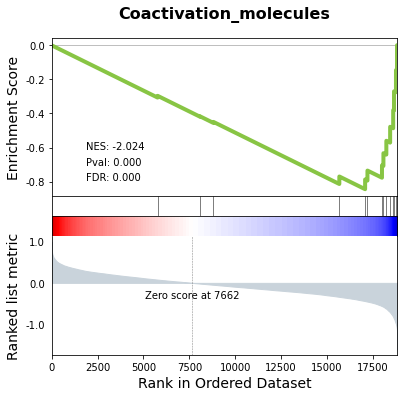

In [ ]:
from gseapy import gseaplot, heatmap

group = "Coactivation_molecules"
gseaplot(gs_res.ranking, term=group, **gs_res.results[group])

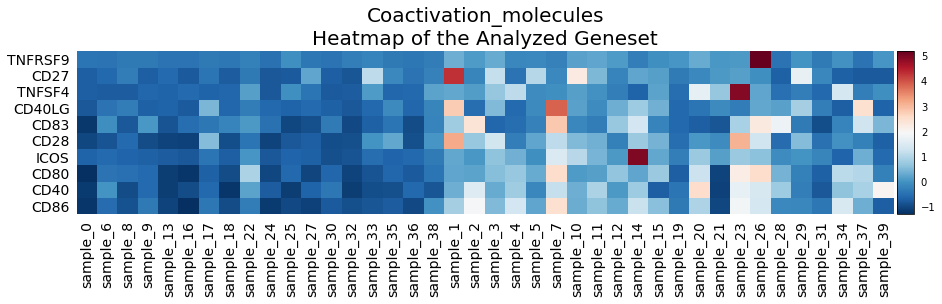

In [ ]:
genes = gs_res.res2d.ledge_genes[group].split(";")
heatmap(df=gs_res.heatmat.loc[genes], z_score=0, title=group,
        figsize=(15, 3))

In [ ]:
gs_res.res2d.tail(5)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
B_cells,-0.660980,-1.053694,0.485769,0.486042,13,13,CR2;BLK;PAX5;TNFRSF13B;MS4A1;TNFRSF13C;CD79A;C...,CR2;BLK;PAX5;TNFRSF13B;MS4A1;TNFRSF13C;CD79A;C...
Granulocyte_traffic,-0.470767,-1.036196,0.444008,0.487533,9,9,CCR3;CXCL1;CXCL5;KITLG;CXCL2;CXCL8;CXCR1;CXCR2...,KITLG;CXCL2;CXCL8;CXCR1;CXCR2;CCL11
Neutrophil_signature,-0.468760,-1.058720,0.402806,0.501115,10,10,FFAR2;ELANE;PRTN3;CTSG;PGLYRP1;CD177;CXCR1;CXC...,CXCR1;CXCR2;MPO;FCGR3B
Matrix,-0.449455,-0.998188,0.463855,0.511332,15,15,LGALS7;VTN;ELN;LGALS9;LAMB3;LAMA3;COL4A1;COL5A...,COL4A1;COL5A1;COL11A1;COL1A2;COL1A1;TNC;COL3A1...
Proliferation_rate,-0.429716,-0.866343,0.624266,0.624093,15,15,AURKB;CCNB1;E2F1;CETN3;AURKA;PLK1;MCM6;MYBL2;C...,AURKA;PLK1;MCM6;MYBL2;CCND1;MCM2;ESCO2;MKI67;C...


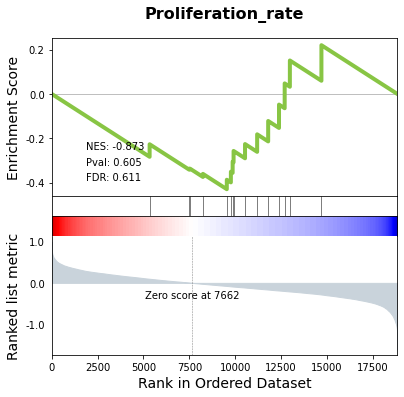

In [ ]:
group = "Proliferation_rate"
gseaplot(gs_res.ranking, term=group, **gs_res.results[group])

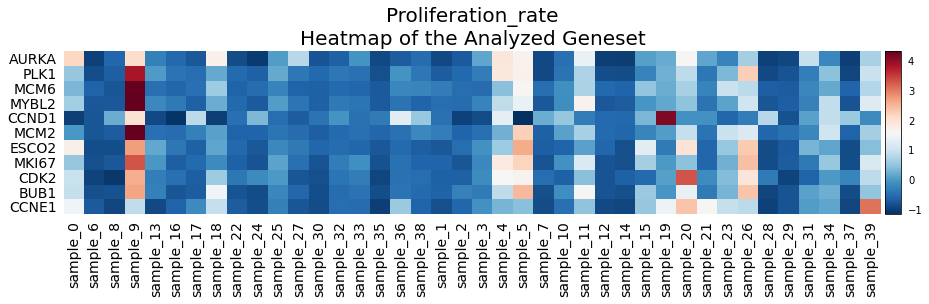

In [ ]:
genes = gs_res.res2d.ledge_genes[group].split(";")
heatmap(df=gs_res.heatmat.loc[genes], z_score=0, title=group,
        figsize=(15, 3))

## Деконволюция bulk RNA-Seq

Существует много готовых инструментов для деконволюции, воспользуемся на сегодняшнем семинаре двумя из них: Ecotyper и Kassandra. Для начала подготовим нашу матрицу экспрессии, чтобы в ней не было дублирующихся названий генов.

In [ ]:
df.iloc[
    np.array([list(df.index).count(gene) for gene in df.index]) == 1
].to_csv("LUAD_tpms_norepet.tsv", sep="\t")

Теперь запустим инструмент <a href="https://ecotyper.stanford.edu">Carcinoma EcoTyper</a> и загрузим его выдачу в Google Colab.

In [ ]:
!mkdir ecotyper && mv ecotyper_output.zip ecotyper/
!cd ecotyper && unzip ecotyper_output.zip

In [ ]:
import os
celltypes = os.listdir("ecotyper/Carcinoma_Cell_States/")

celltype_df = pd.DataFrame()
for celltype in celltypes:
  _ = pd.read_csv(f"ecotyper/Carcinoma_Cell_States/{celltype}/{celltype}_Cell_State_Abundance.txt", sep="\t", index_col=0)
  celltype_df[celltype] = _.sum(axis=1)

In [ ]:
celltype_df.columns

Index(['Epithelial.cells', 'CD4.T.cells', 'NK.cells', 'Mast.cells', 'PCs',
       'Monocytes.and.Macrophages', 'Fibroblasts', 'CD8.T.cells', 'B.cells',
       'Dendritic.cells', 'PMNs', 'Endothelial.cells'],
      dtype='object')

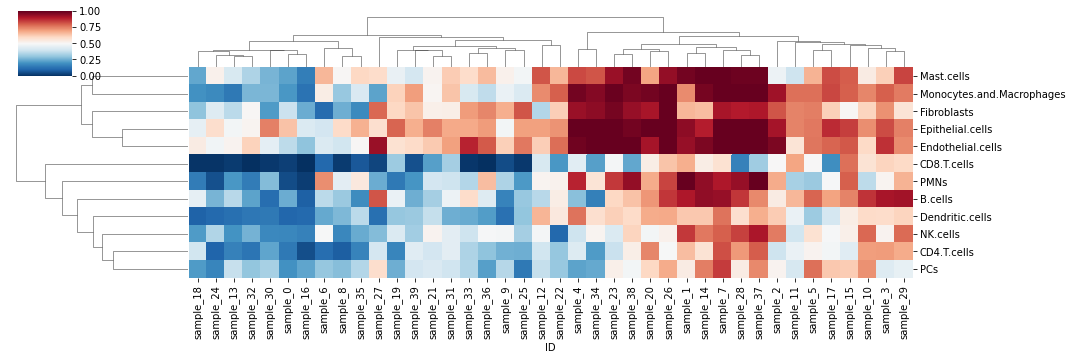

In [ ]:
sns.clustermap(celltype_df.T, figsize=(15, 5), cmap="RdBu_r")

### Задание

Попробуйте самостоятельно запустить алгоритм деконволюции <a href="https://science.bostongene.com/kassandra/">Kassandra</a> и сравните результаты различных деконволюций. Сходятся ли они? В чём разница?

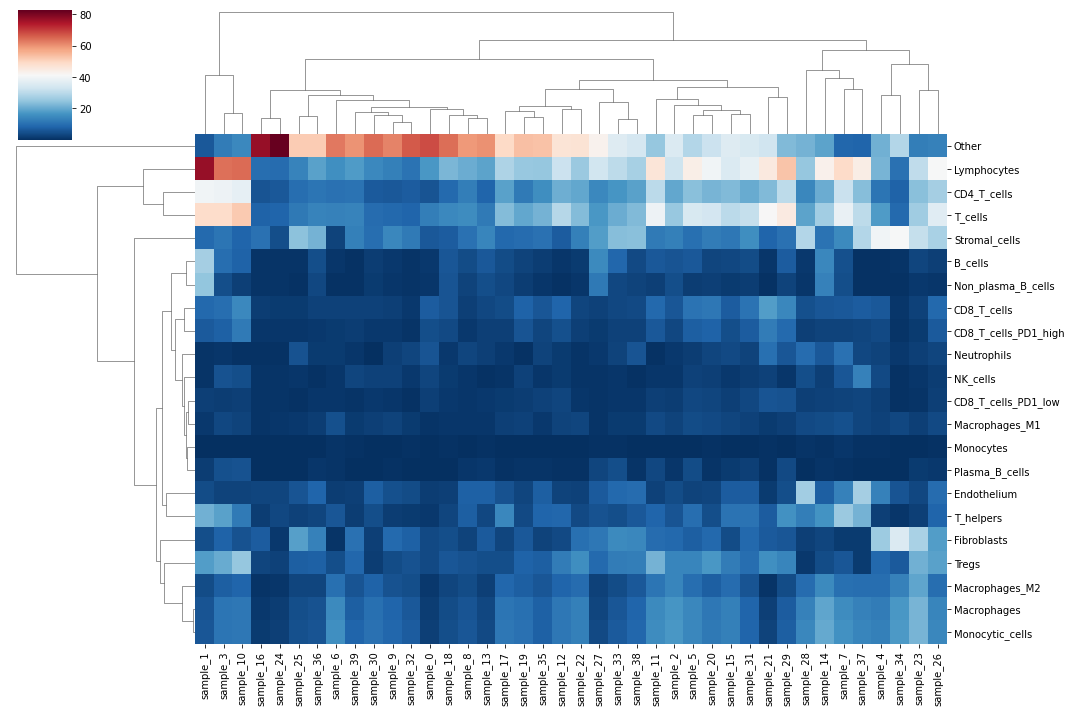

In [ ]:
kass_pred = pd.read_csv("predictions.tsv", sep="\t", index_col=0)
sns.clustermap(kass_pred, figsize=(15, 10), cmap="RdBu_r")

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scaled_data = scale.fit_transform(kass_pred.T)
scaled_data = pd.DataFrame(scaled_data.T, index=kass_pred.index, columns=kass_pred.columns)

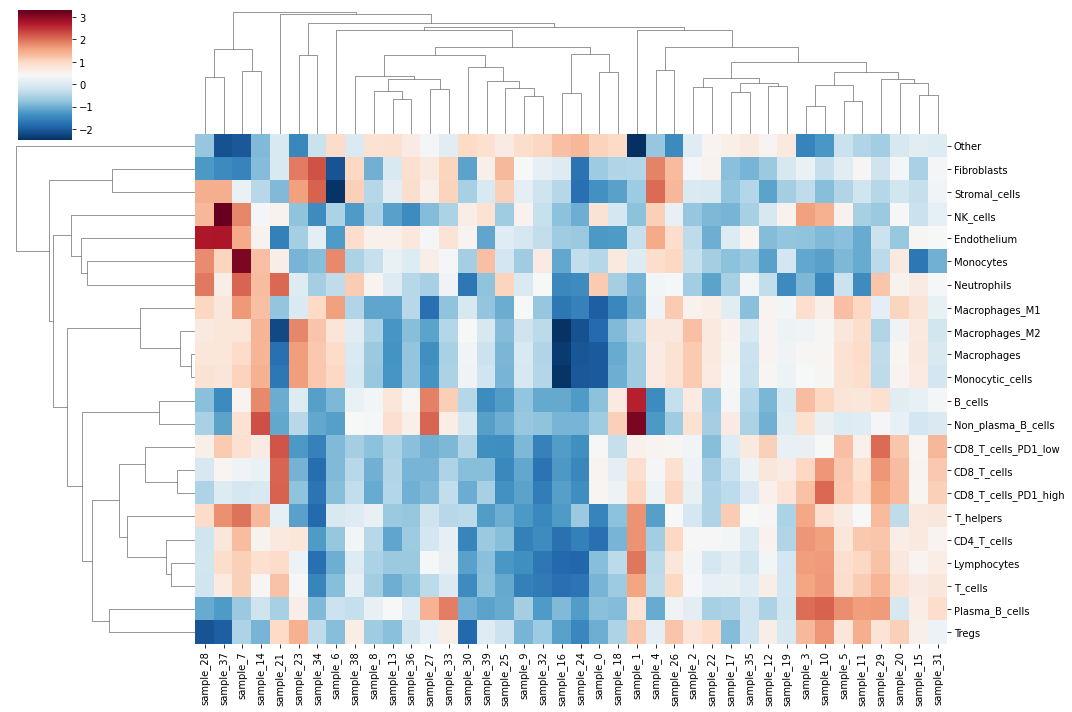

In [ ]:
sns.clustermap(scaled_data, figsize=(15, 10), cmap="RdBu_r")

## Домашнее задание

Скачайте каунты экспрессий для тех же образцов (Google Drive ID: `1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg`) и выполните дифференциальную экспрессию при помощи DESeq2 между кластерами, которые мы определили в начале семинара. Возьмите результат DESeq2, упорядочьте по

1. logFC,
2. —logFDR со знаком logFC,

и попробуйте на этом списке запустить `gsea.prerank` с сигнатурами, которые сегодня уже использовались. Сходится ли результат с тем, что получается при классическом запуске GSEA?